In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [12]:
def draw_graph(adj_list, positions):
    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*positions.T, s=100) #.T-> shape=(3, num_nodes), *-> 3 seperate lists with num_nodes elements each
    for edge in edge_coordinates: #edge shape = (2, 3)
        ax.plot(*edge.T, c="dimgrey", alpha=0.5)

In [31]:
def genLatticeNodes(len_ex, len_ey, len_ez, alpha, beta, gamma, nx_max=20, ny_max=20, nz_max=20, centering_type="P"):
    e_x = len_ex*np.array([1, 0, 0], dtype=float)
    e_y = len_ey*np.array([np.cos(gamma), np.sin(gamma), 0], dtype=float)
    e_z_x = np.cos(alpha)
    e_z_y = 1/np.sin(gamma)*(np.cos(beta)-np.cos(alpha)*np.cos(gamma))
    e_z_z = np.sqrt(1-e_z_x**2 - e_z_y**2)
    e_z = len_ez*np.array([e_z_x, e_z_y, e_z_z], dtype=float)
    
    transform = np.array([e_x, e_y, e_z]).T #[1, 0, 0] -> e_x, [0, 1, 0] -> e_y, [0, 0, 1] -> e_z
    transform_inv = np.linalg.inv(transform)
    num_nodes = nx_max*ny_max*nz_max
    mask_center_node = np.full(shape=(num_nodes, ), fill_value=False, dtype=bool)
    #indices
    ind_pos = np.array(np.meshgrid(np.arange(0, nx_max), np.arange(0, ny_max), np.arange(0, nz_max)), dtype=int).T.reshape(-1, 3) #shape=(num_nodes, 3)
    #positions
    pos = np.array([transform@p for p in ind_pos])
    if centering_type=="P":
        #primitve: done
        pass
    elif centering_type=="S":
        #base-centered
        ind_pos_c = np.array(np.meshgrid(np.arange(0, nx_max-1), np.arange(0, ny_max-1), np.arange(0, nz_max)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
        pos_c = np.array([(transform@p_c + 1/2*e_x + 1/2*e_y) for p_c in ind_pos_c])
        num_nodes += len(ind_pos_c)
        pos = np.concatenate((pos, pos_c), dtype=float)
        mask_center_node = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)

    elif centering_type=="I":
        ind_pos_c = np.array(np.meshgrid(np.arange(0, nx_max-1), np.arange(0, ny_max-1), np.arange(0, nz_max-1)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
        pos_c = np.array([(transform@p_c + 1/2*e_x + 1/2*e_y + 1/2*e_z) for p_c in ind_pos_c])
        num_nodes += len(ind_pos_c)
        pos = np.concatenate((pos, pos_c), dtype=float)
        mask_center_node = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)

    elif centering_type=="F":
        #face-centered
        #top/bottom
        ind_pos_c = np.array(np.meshgrid(np.arange(0, nx_max-1), np.arange(0, ny_max-1), np.arange(0, nz_max)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
        pos_c = np.array([(transform@p_c + 1/2*e_x + 1/2*e_y) for p_c in ind_pos_c])
        num_nodes += len(ind_pos_c)
        pos = np.concatenate((pos, pos_c), dtype=float)
        mask_center_node = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)

        #left/right
        ind_pos_c = np.array(np.meshgrid(np.arange(0, nx_max), np.arange(0, ny_max-1), np.arange(0, nz_max-1)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
        pos_c = np.array([(transform@p_c + 1/2*e_y + 1/2*e_z) for p_c in ind_pos_c])
        num_nodes += len(ind_pos_c)
        pos = np.concatenate((pos, pos_c), dtype=float)
        mask_center_node = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)

        #front/back
        ind_pos_c = np.array(np.meshgrid(np.arange(0, nx_max-1), np.arange(0, ny_max), np.arange(0, nz_max-1)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
        pos_c = np.array([(transform@p_c + 1/2*e_x + 1/2*e_z) for p_c in ind_pos_c])
        num_nodes += len(ind_pos_c)
        pos = np.concatenate((pos, pos_c), dtype=float)
        mask_center_node = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)

        pass

    return mask_center_node, pos, transform, transform_inv

In [24]:
def genAdjacencyList(mask_center_node, positions, transform_inv, radius):
    adj_list = list()
    pos_inv = np.array([transform_inv@p for p in positions])
    num_nodes = len(positions)

    for n in range(num_nodes):
        node_center_pos = pos_inv[n]
        is_center_node = mask_center_node[n]
        for j in range(num_nodes):
            if j == n or (is_center_node and mask_center_node[j]): continue
            node_test_pos = pos_inv[j]
            if np.sqrt(np.sum((node_center_pos - node_test_pos)**2)) < radius:
                adj_list.append([n, j])

    return len(adj_list), adj_list

In [44]:
mask_center_node, pos, transform, transform_inv = genLatticeNodes(1, 1, 1, np.pi/2, np.pi/3, np.pi/2, nx_max=5, ny_max=5, nz_max=5, centering_type="S")
num_edges, adj_list = genAdjacencyList(mask_center_node, pos, transform_inv, 1.05)

#node_values = np.zeros(shape=(num_nodes, ))
#edge_values = np.zeros(shape=(num_edges, ))
#draw_graph(node_values, edge_values, adj_list, pos, axis=True, node_size=40)

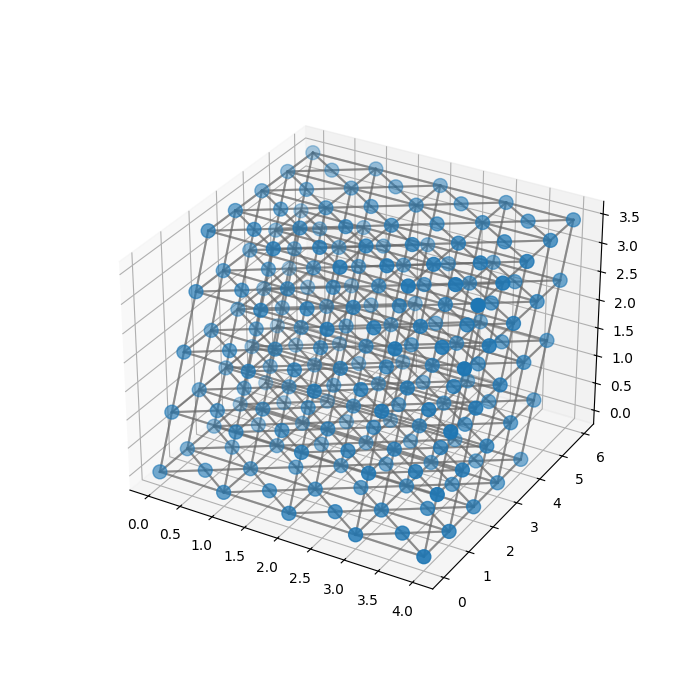

In [45]:
%matplotlib widget 
draw_graph(adj_list, pos)